In [87]:
!pip install idx2numpy

In [88]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import idx2numpy
import random
import pandas as pd
from sklearn import svm, metrics 

Load dataset and convert it to numpy array.

In [89]:
imgsFilePath = "train-images.idx3-ubyte"
labelsFilePath = "train-labels.idx1-ubyte"

images = idx2numpy.convert_from_file(imgsFilePath)
labels = idx2numpy.convert_from_file(labelsFilePath)
# print(images)
# print(images.shape)
# print(labels)
# print(labels.shape)

# keeping only the images with labels 0, 1 and 2:
images = images[labels < 3]
labels = labels[labels < 3]
# print(images)
# print(labels)
print(images.shape)
print(labels.shape)

(18623, 28, 28)
(18623,)


Display random 10 images

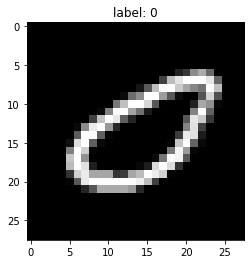

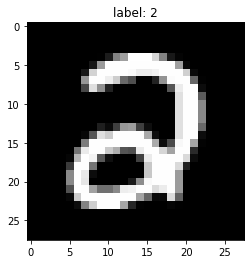

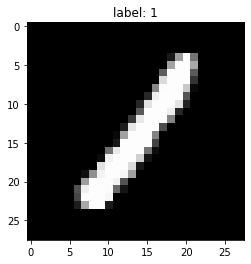

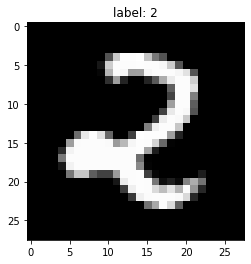

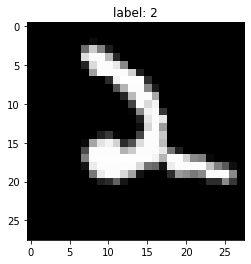

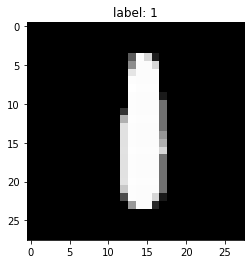

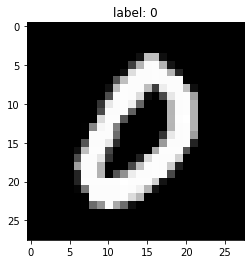

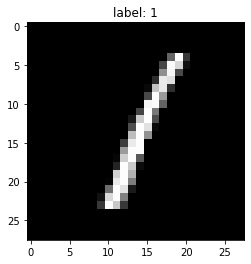

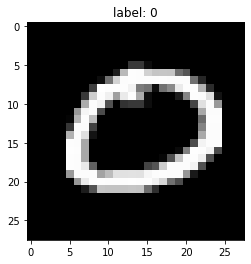

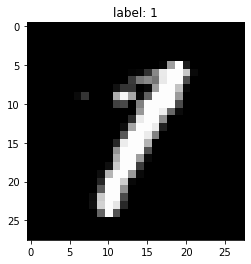

In [90]:
# print(images[0])
# print(labels[0])
# range(len(labels))

def randomTenImages(images, labels):
  for j in range(0, 10):
      i = random.randint(0, len(labels))

      plt.imshow(images[i], cmap='gray')
      plt.title('label: ' + str(labels[i]))
      plt.show()
  
randomTenImages(images, labels)

Split MNIST data into training, validation and test

(13036, 28, 28)
(13036,)


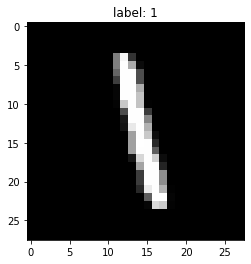

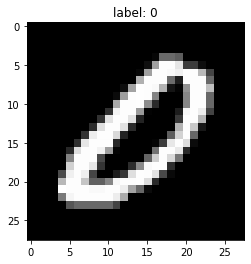

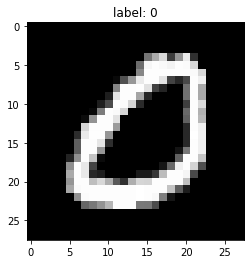

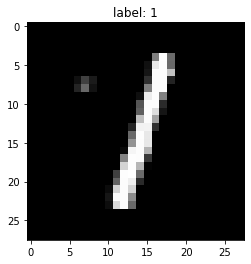

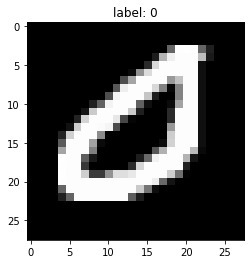

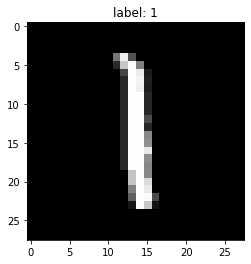

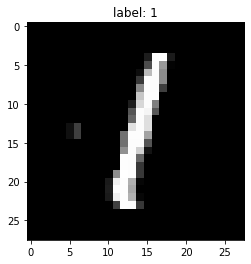

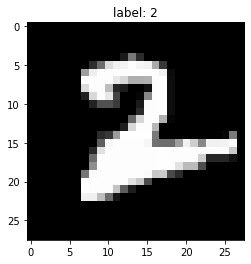

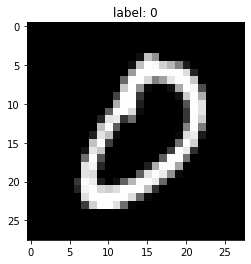

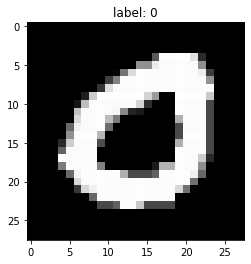

In [91]:
numLabels = labels.shape[0]

trainSetSize = int(0.7 * numLabels)
ValidationSetSize = int(0.2 * numLabels)
testSetSize = int(0.1 * numLabels)
# print(trainSetSize)
# print(ValidationSetSize)
# print(testSetSize)

trainImages = images[:trainSetSize, :]
trainLabels = labels[:trainSetSize]
validationImages = images[trainSetSize:trainSetSize+ValidationSetSize, :]
validationLabels = labels[trainSetSize:trainSetSize+ValidationSetSize]
testImages = images[trainSetSize+ValidationSetSize:, :]
testLabels = labels[trainSetSize+ValidationSetSize:]
print(trainImages.shape)
print(trainLabels.shape)
# print(validationImages.shape)
# print(validationLabels.shape)
# print(testImages.shape)
# print(testLabels.shape)

# testing if data is split correctly (tried for all 3 splits)
randomTenImages(testImages, testLabels)

## 2.1 Preprocessing: Low pass filter to remove noise and then binarize images

In [92]:
def preProcessingImgs(Images):
  for i in range(len(Images)):
    blurImg = cv2.GaussianBlur(Images[i], (3,3), 0)

    # binarize as well
    _, Images[i] = cv2.threshold(blurImg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  return Images    

trainImages = preProcessingImgs(trainImages)
# randomTenImages(trainImages, trainLabels)

## 2.2 Feature Extraction: Extract Contours

In [93]:
def featureExtraction(images, labels):
  featArray = np.empty((0, 8))

  for i in range(len(images)):
    contours, _ = cv2.findContours(images[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    _, _, width, height = cv2.boundingRect(cnt)
    
    # calculate moments for the contour
    M = cv2.moments(cnt)

    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
    else:
      cX, cY = 0, 0

    
    X_1 = cv2.countNonZero(images[i])
    X_2 = float(width / height)
    X_3 = cv2.contourArea(cnt)
    X_4 = cv2.arcLength(cnt, True)
    X_5 = cX
    X_6 = cY
    X_7 = width

    featArray = np.append(featArray, np.array([[X_1, X_2, X_3, X_4, X_5, X_6, X_7, int(labels[i])]]), axis=0)
  
  return featArray

featArray = featureExtraction(trainImages, trainLabels)
# my list has 8 elements because I am considering both moments i.e. along x and y direction,
# and also label is added for further processing
print(featArray.shape)
print(featArray[500])

(13036, 8)
[174.           0.95       254.5         61.69848394  14.
  15.          19.           0.        ]


Display mean and variance

In [94]:
print(len(featArray))
# print(featArray[400][-1])

featArray_digit0 = np.empty((0, 8))
featArray_digit1 = np.empty((0, 8))
featArray_digit2 = np.empty((0, 8))

# splitting the each digits feature vectors to plot mean and variance
for i in range(len(featArray)):

  if featArray[i][-1] == 0:
    featArray_digit0 = np.append(featArray_digit0, [featArray[i]], axis=0)
  elif featArray[i][-1] == 1:
    featArray_digit1 = np.append(featArray_digit1, [featArray[i]], axis=0)
  elif featArray[i][-1] == 2:
    featArray_digit2 = np.append(featArray_digit2, [featArray[i]], axis=0)
  else:
    print("Something went wrong!!")

# print(len(featArray_digit0))
# print(len(featArray_digit1))
# print(len(featArray_digit2))

13036


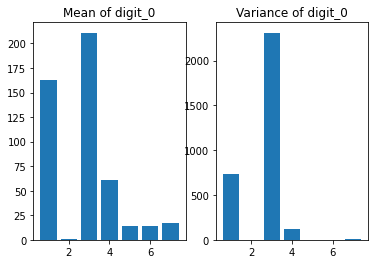

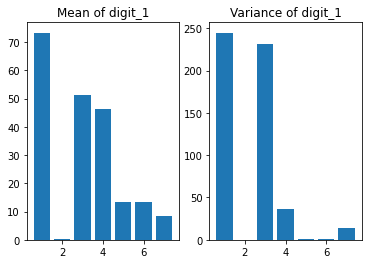

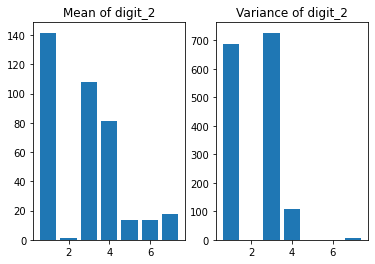




Mean Features Table:
         Non-zero Pxls     W / H        Area  Perimeter   Moment_X   Moment_Y  \
Digit_0     162.992012  0.918013  210.915759  61.230433  13.594529  13.627693   
Digit_1      73.300524  0.429090   51.181571  46.352767  13.516021  13.418848   
Digit_2     141.578692  0.944999  107.986683  81.201382  13.361743  13.737046   

                 W  
Digit_0  17.548293  
Digit_1   8.477906  
Digit_2  17.624939  

Variance Features Table:
         Non-zero Pxls     W / H         Area   Perimeter  Moment_X  Moment_Y  \
Digit_0     736.358929  0.033930  2311.126890  124.000329  0.637578  0.629240   
Digit_1     244.770628  0.036933   231.806509   36.645001  0.932466  0.886346   
Digit_2     685.591992  0.050183   726.153576  108.739073  0.433791  0.490177   

                 W  
Digit_0   6.922565  
Digit_1  14.183334  
Digit_2   6.930274  


In [95]:
def findMeanVariance(featVector):

  mean = np.mean(featVector, axis=0)
  variance = np.var(featVector, axis=0)

  # print(f'digit: {featVector[0][-1]} \n mean: {mean}, \nvariance: {variance}', end='\n\n')

  plt.subplot(121), plt.bar([1,2,3,4,5,6,7], mean[:7]), 
  plt.title(f"Mean of digit_{featVector[0][-1]:.0f}")
  plt.subplot(122), plt.bar([1,2,3,4,5,6,7], variance[:7]), 
  plt.title(f"Variance of digit_{featVector[0][-1]:.0f}")
  plt.show()

  print("\n")

  return mean, variance

mean_digit0, var_digit0 = findMeanVariance(featArray_digit0)
mean_digit1, var_digit1 = findMeanVariance(featArray_digit1)
mean_digit2, var_digit2 = findMeanVariance(featArray_digit2)

mean_array = np.array([mean_digit0[:7], mean_digit1[:7], mean_digit2[:7]])
var_array = np.array([var_digit0[:7], var_digit1[:7], var_digit2[:7]])

# print(mean_array)

meanFeatDF = pd.DataFrame(mean_array, 
                  columns = ['Non-zero Pxls', 'W / H', 'Area', 'Perimeter', 
                                         'Moment_X', 'Moment_Y', 'W'],
                  index = ['Digit_0', 'Digit_1', 'Digit_2'])

varFeatDF = pd.DataFrame(var_array, 
                  columns = ['Non-zero Pxls', 'W / H', 'Area', 'Perimeter', 
                                         'Moment_X', 'Moment_Y', 'W'],
                  index = ['Digit_0', 'Digit_1', 'Digit_2'])

print("\nMean Features Table:")
print(meanFeatDF)
print("\nVariance Features Table:")
print(varFeatDF)

## 2.3 Dimension Reduction - Apply PCA


2 Components PCA:
 [[123.61376912 -33.62377098]
 [-44.79451564  -1.00425449]
 [ 65.34647766  28.91988212]
 ...
 [ 85.79619622  31.48355083]
 [-14.13739706  14.79748291]
 [  9.43296869  17.68718319]]
(13036, 2)


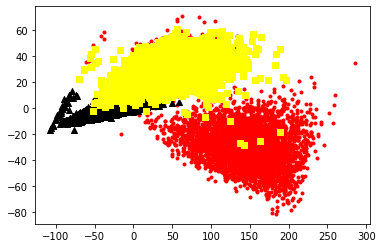

In [96]:
def dimensionReductionWithPlot(features, labels, numComponents):
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(features[0:7], mean, maxComponents=numComponents)
  # print(f"{mean}, \n{eigenvectors}, \n{eigenvalues}")

  featArray7 = features[:]
  # print(featArray7.shape)

  numComponentTrainingSet = cv2.PCAProject(featArray7, mean, eigenvectors)
  
  if numComponents == 2:
    print(f"\n{numComponents} Components PCA:\n {numComponentTrainingSet}")
    print(numComponentTrainingSet.shape)

    plt.scatter((numComponentTrainingSet[:,0])[np.isin(labels, 0)], (numComponentTrainingSet[:,1])[np.isin(labels, 0)], color='red', marker='.')
    plt.scatter((numComponentTrainingSet[:,0])[np.isin(labels, 1)], (numComponentTrainingSet[:,1])[np.isin(labels, 1)], color='black', marker='^')
    plt.scatter((numComponentTrainingSet[:,0])[np.isin(labels, 2)], (numComponentTrainingSet[:,1])[np.isin(labels, 2)], color='yellow', marker='s')
    plt.show()

  return numComponentTrainingSet

twoPCAComponentTraining = dimensionReductionWithPlot(featArray, trainLabels, 2)

## 2.4 Classification: Train SVM and plot confusion matrix

In [97]:
def svmClassifier(trainingData, labels):
  #Create a svm Classifier
  clf = svm.SVC(kernel='rbf', C=0.55) 

  #Train the model using the training sets
  clf.fit(trainingData, labels)

  #Predict the response for test dataset
  PredictedTwoComponent = clf.predict(trainingData)
  accuracy = metrics.accuracy_score(labels, PredictedTwoComponent)
  # print("Accuracy:", accuracy)
  # print(metrics.confusion_matrix(labels, PredictedTwoComponent))

  return clf

twoComponentClf = svmClassifier(twoPCAComponentTraining, trainLabels)

In [98]:
# #Predict the response for test dataset
# PredictedTwoComponent = clf.predict(twoPCAComponentTraining)
# accuracy = metrics.accuracy_score(trainLabels, PredictedTwoComponent)
# print("Accuracy:", accuracy)

Confusion Matrix: with 2 PCA components

In [99]:
# metrics.confusion_matrix(trainLabels, PredictedTwoComponent)

# 2.5 Optimizing number of components

Training Accuracy of 7 components:

Training Accuracy: 0.9634857318195765
Training Confusion Matrix:
[[3829   12  290]
 [   2 4689   84]
 [  24   64 4042]]

Validation Accuracy of 0 components:

Validation Accuracy: 0.7956498388829216
Validation Confusion Matrix:
[[ 888  117  182]
 [ 351  965    8]
 [  15   88 1110]]
###########################################


Training Accuracy of 1 components:

Training Accuracy: 0.8711261123043879
Training Confusion Matrix:
[[3353   18  760]
 [   0 4492  283]
 [ 344  275 3511]]

Validation Accuracy of 1 components:

Validation Accuracy: 0.43447905477980664
Validation Confusion Matrix:
[[ 272  121  794]
 [ 230 1094    0]
 [   6  955  252]]
###########################################



2 Components PCA:
 [[123.61376912 -33.62377098]
 [-44.79451564  -1.00425449]
 [ 65.34647766  28.91988212]
 ...
 [ 85.79619622  31.48355083]
 [-14.13739706  14.79748291]
 [  9.43296869  17.68718319]]
(13036, 2)


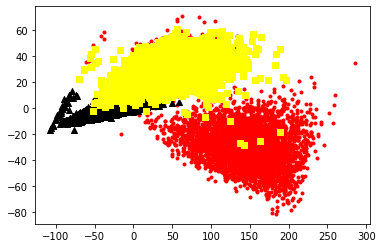


2 Components PCA:
 [[-93.22194713  -9.99403536]
 [124.32519863  16.77738255]
 [-61.63812517   3.33273713]
 ...
 [ 68.22773606 -18.67956537]
 [117.35186507 -17.18699836]
 [-38.43136112  25.06797007]]
(3724, 2)


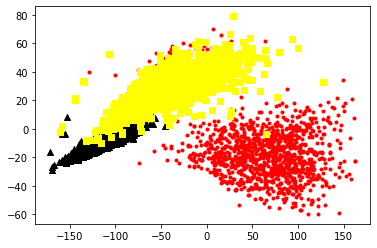

Training Accuracy of 2 components:

Training Accuracy: 0.9604940165694998
Training Confusion Matrix:
[[3809   18  304]
 [   2 4677   96]
 [  20   75 4035]]

Validation Accuracy of 2 components:

Validation Accuracy: 0.8289473684210527
Validation Confusion Matrix:
[[ 832  206  149]
 [ 119 1201    4]
 [  20  139 1054]]
###########################################


Training Accuracy of 3 components:

Training Accuracy: 0.9625652040503222
Training Confusion Matrix:
[[3827   13  291]
 [   2 4682   91]
 [  23   68 4039]]

Validation Accuracy of 3 components:

Validation Accuracy: 0.7814178302900108
Validation Confusion Matrix:
[[ 894  123  170]
 [ 403  914    7]
 [  20   91 1102]]
###########################################


Training Accuracy of 4 components:

Training Accuracy: 0.9634090211721387
Training Confusion Matrix:
[[3829   12  290]
 [   2 4688   85]
 [  24   64 4042]]

Validation Accuracy of 4 components:

Validation Accuracy: 0.7951127819548872
Validation Confusion Matrix:
[[ 891

In [100]:
# validation accuracy 
# first need to process the validation data

validationImages = preProcessingImgs(validationImages)
validationFeatures = featureExtraction(validationImages, validationLabels)

# test the models for all 7 components:

for i in range(0, 7):
  i_dimensionsFeatures = dimensionReductionWithPlot(featArray, trainLabels, i)
  i_ValidationFeatures = dimensionReductionWithPlot(validationFeatures, validationLabels, i)

  if i == 0:
    print(f"Training Accuracy of 7 components:\n")
  else:
    print(f"Training Accuracy of {i} components:\n")

  clf = svmClassifier(i_dimensionsFeatures, trainLabels)

  Predicted_i_Training_Component = clf.predict(i_dimensionsFeatures)
  TrainingAccuracy = metrics.accuracy_score(trainLabels, Predicted_i_Training_Component)
  print("Training Accuracy:", TrainingAccuracy)
  print("Training Confusion Matrix:")
  print(metrics.confusion_matrix(trainLabels, Predicted_i_Training_Component))


  print(f"\nValidation Accuracy of {i} components:\n")
  Predicted_i_Validation_Component = clf.predict(i_ValidationFeatures)
  ValidationAccuracy = metrics.accuracy_score(validationLabels, Predicted_i_Validation_Component)
  print("Validation Accuracy:", ValidationAccuracy)
  print("Validation Confusion Matrix:")
  print(metrics.confusion_matrix(validationLabels, Predicted_i_Validation_Component))
  print("###########################################")
  print(end='\n\n')

# 2.6 Evaluation


2 Components PCA:
 [[123.61376912 -33.62377098]
 [-44.79451564  -1.00425449]
 [ 65.34647766  28.91988212]
 ...
 [ 85.79619622  31.48355083]
 [-14.13739706  14.79748291]
 [  9.43296869  17.68718319]]
(13036, 2)


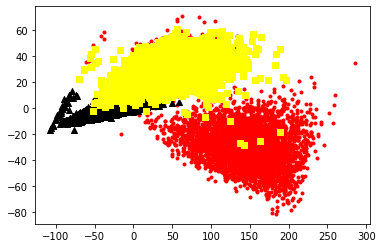


2 Components PCA:
 [[-115.24069834  -23.36739677]
 [-117.40055732  -22.98015419]
 [   3.71850707   24.85547992]
 ...
 [  97.57162651  -13.84829254]
 [ -40.01946193   21.07111412]
 [-110.89036366  -16.6060329 ]]
(1863, 2)


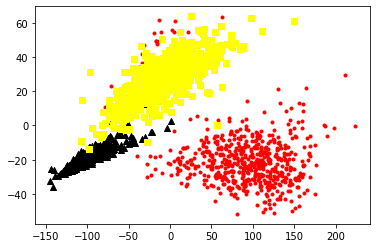

Training Accuracy: 0.9604940165694998
Training Confusion Matrix:
[[3809   18  304]
 [   2 4677   96]
 [  20   75 4035]]

Test Accuracy of 2 components:

Test Accuracy: 0.917337627482555
Test Confusion Matrix:
[[517  49  39]
 [  1 638   4]
 [  3  58 554]]


In [101]:
# first need to process the test data

optimal_n = 2

testImages = preProcessingImgs(testImages)
testFeatures = featureExtraction(testImages, testLabels)

two_dimensionsFeatures = dimensionReductionWithPlot(featArray, trainLabels, optimal_n)
two_testFeatures = dimensionReductionWithPlot(testFeatures, testLabels, optimal_n)

clf = svmClassifier(two_dimensionsFeatures, trainLabels)

PredictedTraining_Component = clf.predict(two_dimensionsFeatures)
TrainingAccuracy = metrics.accuracy_score(trainLabels, PredictedTraining_Component)
print("Training Accuracy:", TrainingAccuracy)
print("Training Confusion Matrix:")
print(metrics.confusion_matrix(trainLabels, PredictedTraining_Component))


print(f"\nTest Accuracy of {optimal_n} components:\n")
PredictedTest_Component = clf.predict(two_testFeatures)
TestAccuracy = metrics.accuracy_score(testLabels, PredictedTest_Component)
print("Test Accuracy:", TestAccuracy)
print("Test Confusion Matrix:")
print(metrics.confusion_matrix(testLabels, PredictedTest_Component))

10 Random images that are correctly classified and 10 images that are incorrectly classified

Correct image # 0, true classification at index: 0


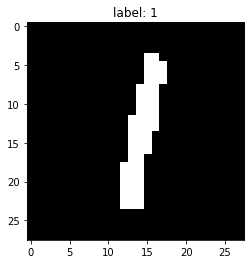


Correct image # 1, true classification at index: 1


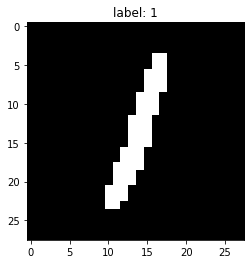


Correct image # 2, true classification at index: 2


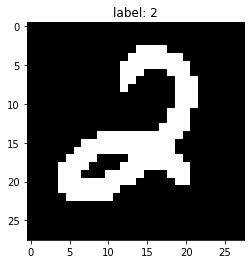


Correct image # 3, true classification at index: 3


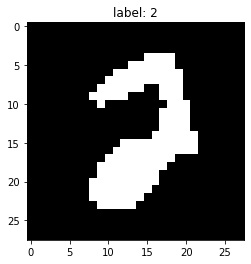


Correct image # 4, true classification at index: 4


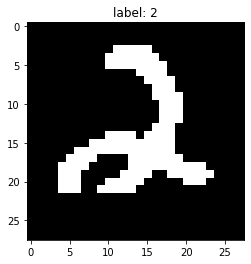


Correct image # 5, true classification at index: 5


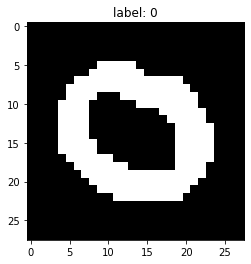


Correct image # 6, true classification at index: 6


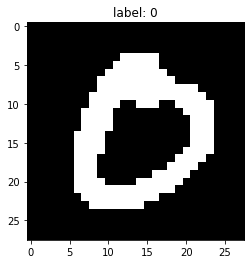


Correct image # 7, true classification at index: 7


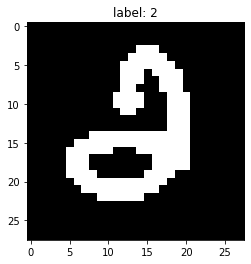


Correct image # 8, true classification at index: 8


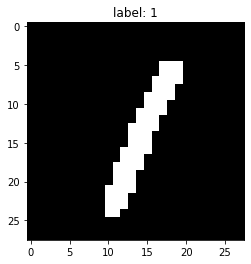


Correct image # 9, true classification at index: 9


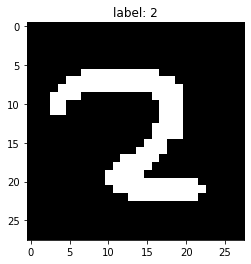


Incorrect image # 0, false classification at index: 19


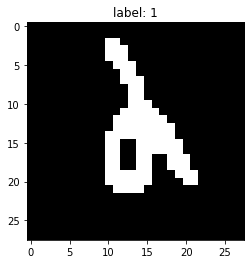


Incorrect image # 1, false classification at index: 26


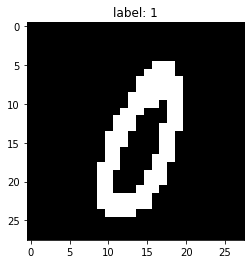


Incorrect image # 2, false classification at index: 33


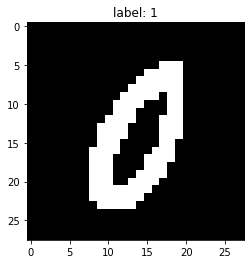


Incorrect image # 3, false classification at index: 45


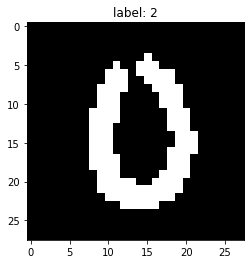


Incorrect image # 4, false classification at index: 46


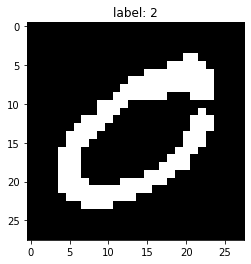


Incorrect image # 5, false classification at index: 49


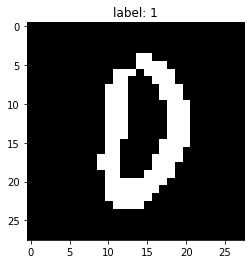


Incorrect image # 6, false classification at index: 70


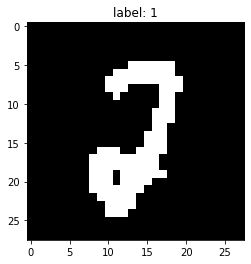


Incorrect image # 7, false classification at index: 76


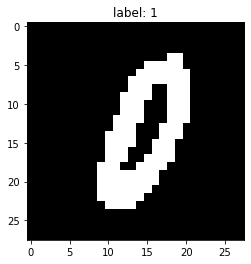


Incorrect image # 8, false classification at index: 83


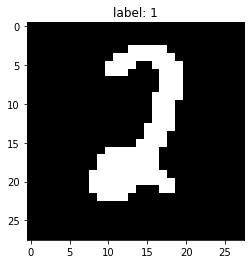


Incorrect image # 9, false classification at index: 84


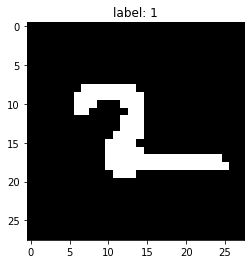

In [102]:
# print(PredictedTest_Component)
# print(testLabels)

# print((PredictedTest_Component==testLabels).all())

comparisonList = np.equal(PredictedTest_Component, testLabels)
comparisonList.shape

FalseDetected = 0
TrueDetected = 0
for i, Value in enumerate(comparisonList):
  # print(i, Value)
  if Value == False and FalseDetected < 10:
    # print(PredictedTest_Component[i], testLabels[i], Value)
    print(f'Incorrect image # {FalseDetected}, false classification at index: {i}')
    FalseDetected += 1
  
    plt.imshow(testImages[i], cmap='gray')
    plt.title('label: ' + str(PredictedTest_Component[i]))
    plt.show()
    print()

  elif Value == True and TrueDetected < 10:
    # print(PredictedTest_Component[i], testLabels[i], Value)
    print(f'Correct image # {TrueDetected}, true classification at index: {i}')
    TrueDetected += 1

    plt.imshow(testImages[i], cmap='gray')
    plt.title('label: ' + str(PredictedTest_Component[i]))
    plt.show()
    print()

  if FalseDetected == 10 and TrueDetected == 10:
    break